# Construct TCA and OxPhos Pathways and Diagrams
__Notes__
- We use ChEBI as the origin for most metabolite definitions
  - No access or licensing restrictions
  - The precision and granularity we need, e.g. in terms of protonation states, isomeric forms, etc
- Likewise, RHEA is the origin for reaction definitions.
- However, those sources themselves do not serve our overall goals. So we construct and refine canonical KB versions of all the relevant items. The path is
> EC number -> RHEA reaction -> ChEBI compound -> KB compound -> KB reaction
- Start with EC numbers pulled from reference sources.
  - The starting lists are fairly inclusive, so we may be selective about what we include in any final pathways.

In [1]:
import collections
import copy
from importlib.resources import files
from ipydatagrid import DataGrid
import json
import pandas as pd
from IPython.display import SVG, display

from mosmo.knowledge import kb
from mosmo.model import DS, DbXref, KbEntry, Molecule, Reaction, Pathway, Specialization, Variation
from mosmo.preso.escher import escher_map, escher_model

import edit_tasks

# Data files are resources in the `data` package.
import data
def datafile(filename):
    return files(data).joinpath(filename)

KB = kb.configure_kb()

## TCA

### Collect RHEA reactions cross-referenced to EC numbers

In [2]:
tca_rhea, tca_chebi = edit_tasks.collect_reference_objects(datafile('tca.txt'), KB, KB.RHEA)
print(f'Collected {len(tca_rhea)} reactions on {len(tca_chebi)} molecules')

Collected 20 reactions on 32 molecules


### Manually curate KB compounds
- Assign or edit kbid, name, akas, shorthand, and xrefs
- Generally, any new entry inherits anything it can from the ChEBI entry
- Manually mark KB entries to be updated

In [3]:
tasks = edit_tasks.build_mol_edit_tasks(tca_chebi, KB, KB.compounds)
print(f'{len(tasks)} molecules to edit, {len([task for task in tasks if task.kb_mol.id])} mapped to existing KB molecules')
mol_edit_grid = edit_tasks.MolEditGrid(tasks)
display(mol_edit_grid.grid)

32 molecules to edit, 30 mapped to existing KB molecules


DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

In [4]:
for task in mol_edit_grid.tasks:
    if task.defunct_kb_id:
        print("Defunct: " + task.defunct_kb_id)
    if task.dirty:
        print(task.kb_mol)
        KB.put(KB.compounds, task.kb_mol)
        task.dirty = False

tca_kb_mols = [task.kb_mol for task in mol_edit_grid.tasks if task.kb_mol.id]

### Build KB versions of all reactions

In [5]:
tasks, skipped = edit_tasks.build_rxn_edit_tasks(tca_rhea, KB, KB.reactions, KB.compounds)
print(f'{len(tasks)} reactions to edit, {len([task for task in tasks if task.kb_rxn.id])} mapped to existing KB reactions')
for rhea_rxn in skipped:
    print(f'Skipped: [{rhea_rxn.id}] {rhea_rxn.name}')

rxn_edit_grid = edit_tasks.RxnEditGrid(tasks)
display(rxn_edit_grid.grid)

19 reactions to edit, 18 mapped to existing KB reactions
Skipped: [75711] succinate dehydrogenase


DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

In [6]:
for task in rxn_edit_grid.tasks:
    if task.defunct_kb_id:
        print("Defunct: " + task.defunct_kb_id)
    if task.dirty:
        print(task.kb_rxn)
        KB.put(KB.reactions, task.kb_rxn)
        task.dirty = False

tca_kb_rxns = [task.kb_rxn for task in rxn_edit_grid.tasks if task.kb_rxn.id]

## Oxidative Phosphorylation

In [7]:
oxphos_rhea, oxphos_chebi = edit_tasks.collect_reference_objects(datafile('etc_oxphos.txt'), KB, KB.RHEA)
print(f'Collected {len(tca_rhea)} reactions on {len(tca_chebi)} molecules')

tasks = edit_tasks.build_mol_edit_tasks(oxphos_chebi, KB, KB.compounds)
print(f'{len(tasks)} molecules to edit, {len([task for task in tasks if task.kb_mol.id])} mapped to existing KB molecules')
mol_edit_grid = edit_tasks.MolEditGrid(tasks)
display(mol_edit_grid.grid)

Collected 20 reactions on 32 molecules
12 molecules to edit, 12 mapped to existing KB molecules


DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

In [8]:
for task in mol_edit_grid.tasks:
    if task.defunct_kb_id:
        print("Defunct: " + task.defunct_kb_id)
    if task.dirty:
        print(task.kb_mol)
        KB.put(KB.compounds, task.kb_mol)
        task.dirty = False

oxphos_kb_mols = [task.kb_mol for task in mol_edit_grid.tasks if task.kb_mol.id]

*Curation Note:*

ChEBI does not differentiate by compartment, _i.e._ there is no separate entry for H+[e]. RHEA resolves this with its own structure to define separate pools, but they map to the same ChEBI entries. As a result, the left and right sides of the reaction cancel out and the stoichiometry is incorrect.

For the KB reactions below we have manually edited the stoichiometry to match the intent. This is not necessarily scalable though, so we will need a more systematic way to handle things if _e.g._ we want to import a large number of transport reactions. TBD.

In [9]:
tasks, skipped = edit_tasks.build_rxn_edit_tasks(oxphos_rhea, KB, KB.reactions, KB.compounds)
print(f'{len(tasks)} reactions to edit, {len([task for task in tasks if task.kb_rxn.id])} mapped to existing KB reactions')
for rhea_rxn in skipped:
    print(f'Skipped: [{rhea_rxn.id}] {rhea_rxn.name}')

rxn_edit_grid = edit_tasks.RxnEditGrid(tasks)
display(rxn_edit_grid.grid)

6 reactions to edit, 6 mapped to existing KB reactions


DataGrid(auto_fit_params={'area': 'all', 'padding': 30, 'numCols': None}, corner_renderer=None, default_render…

In [10]:
for task in rxn_edit_grid.tasks:
    if task.defunct_kb_id:
        print("Defunct: " + task.defunct_kb_id)
    if task.dirty:
        print(task.kb_rxn)
        KB.put(KB.reactions, task.kb_rxn)
        task.dirty = False

oxphos_kb_rxns = [task.kb_rxn for task in rxn_edit_grid.tasks if task.kb_rxn.id]

### This writes the `model` file taken as input by escher.github.io
- uncomment to run, of course

In [11]:
# model = escher_model.escher_model('tca_oxphos', tca_kb_rxns + oxphos_kb_rxns)
# with open('tca_oxphos.model.json', 'wt') as f:
#     f.write(json.dumps(model))

## Tie pathway definitions to Escher diagrams
- Diagrams drawn using [Escher](https://escher.github.io)
- That tool continues to work but is unfortunately not still maintained
- To embed in notebooks we use mosmo.preso.escher.escher_map.EscherMap

In [12]:
def build_pathway(pwid, name=None):
    map_json = json.loads(datafile(f'{pwid}.json').read_text())
    diag = escher_map.EscherMap(map_json)

    pw_reactions = []
    for rnode in diag.reactions:
        kb_rxn = KB.get(KB.reactions, rnode.reaction_id)
        if kb_rxn:
            pw_reactions.append(kb_rxn)
        else:
            print(f'{rnode.reaction_id} not found')

    return Pathway(
        id = pwid,
        name = name or pwid,
        reactions = pw_reactions,
        diagram = map_json,
    )

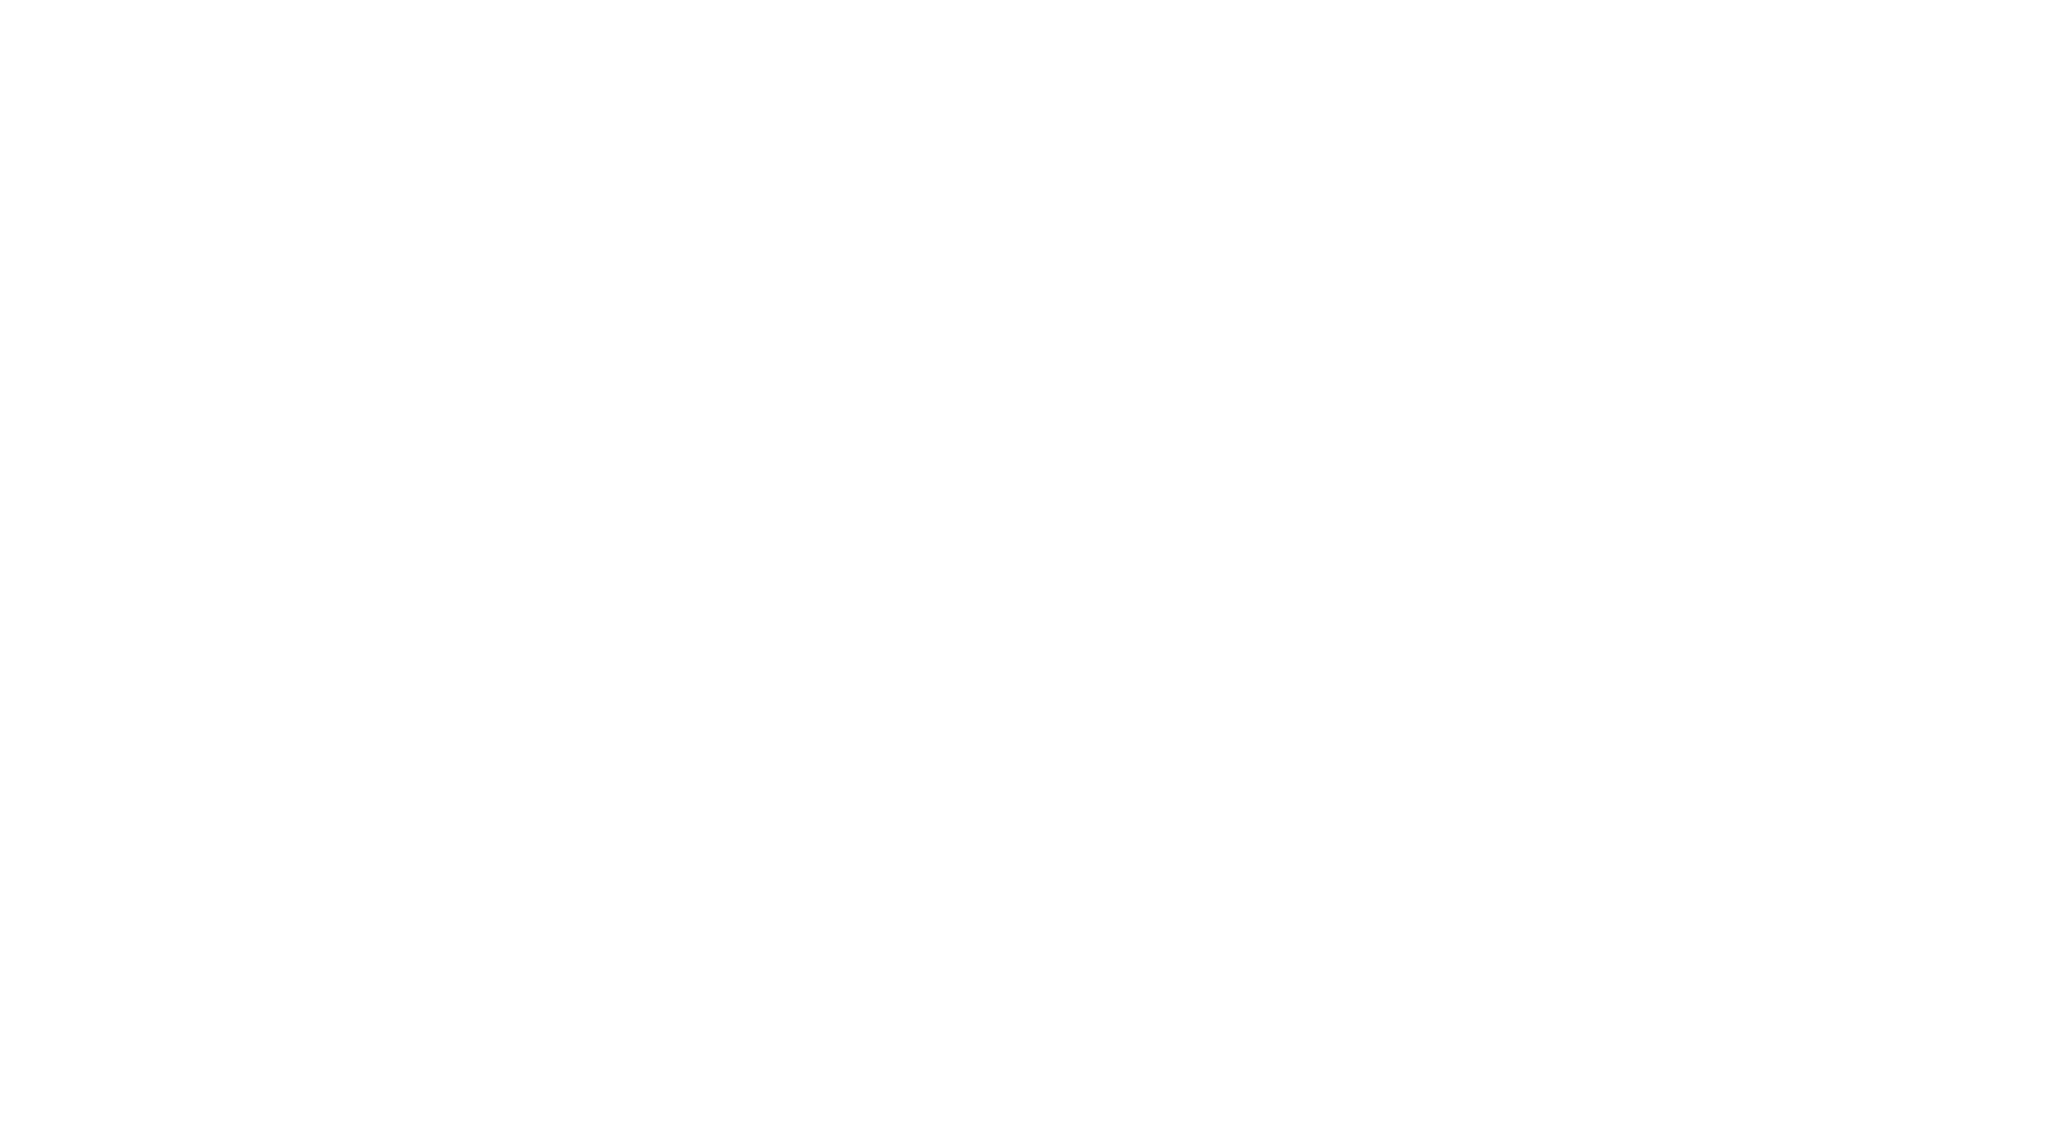

In [13]:
tca = build_pathway('tca_cycle', 'TCA cycle')
SVG(escher_map.EscherMap(tca.diagram, width='20cm').draw())

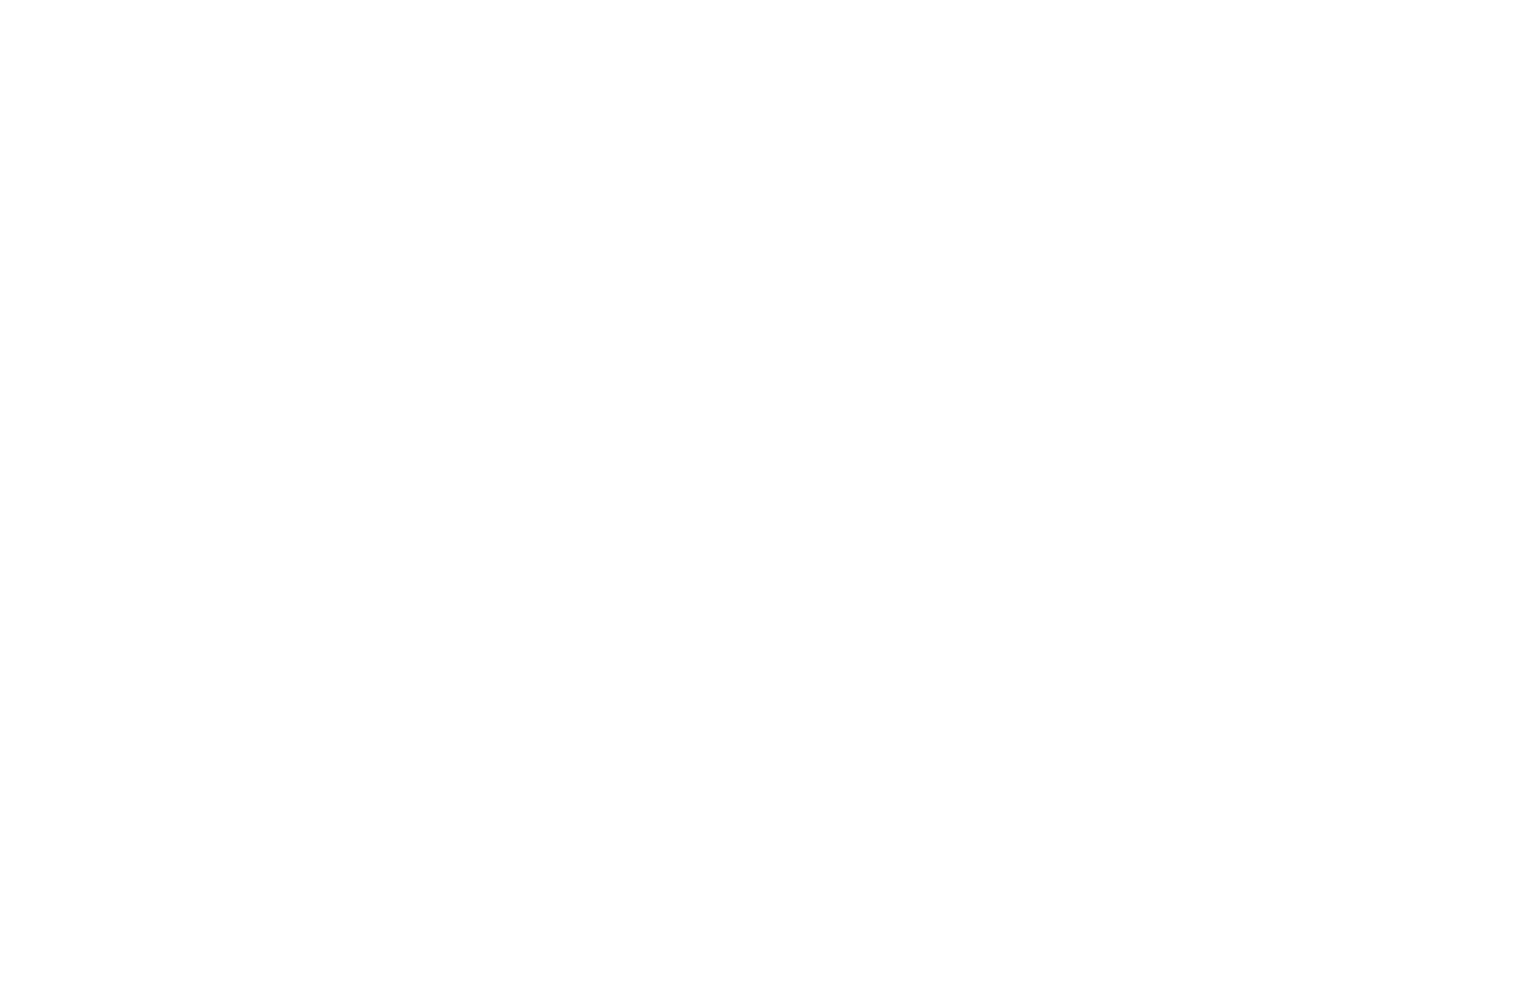

In [14]:
oxphos = build_pathway('oxphos', 'Oxidative Phosporylation')
SVG(escher_map.EscherMap(oxphos.diagram, width='10cm').draw())

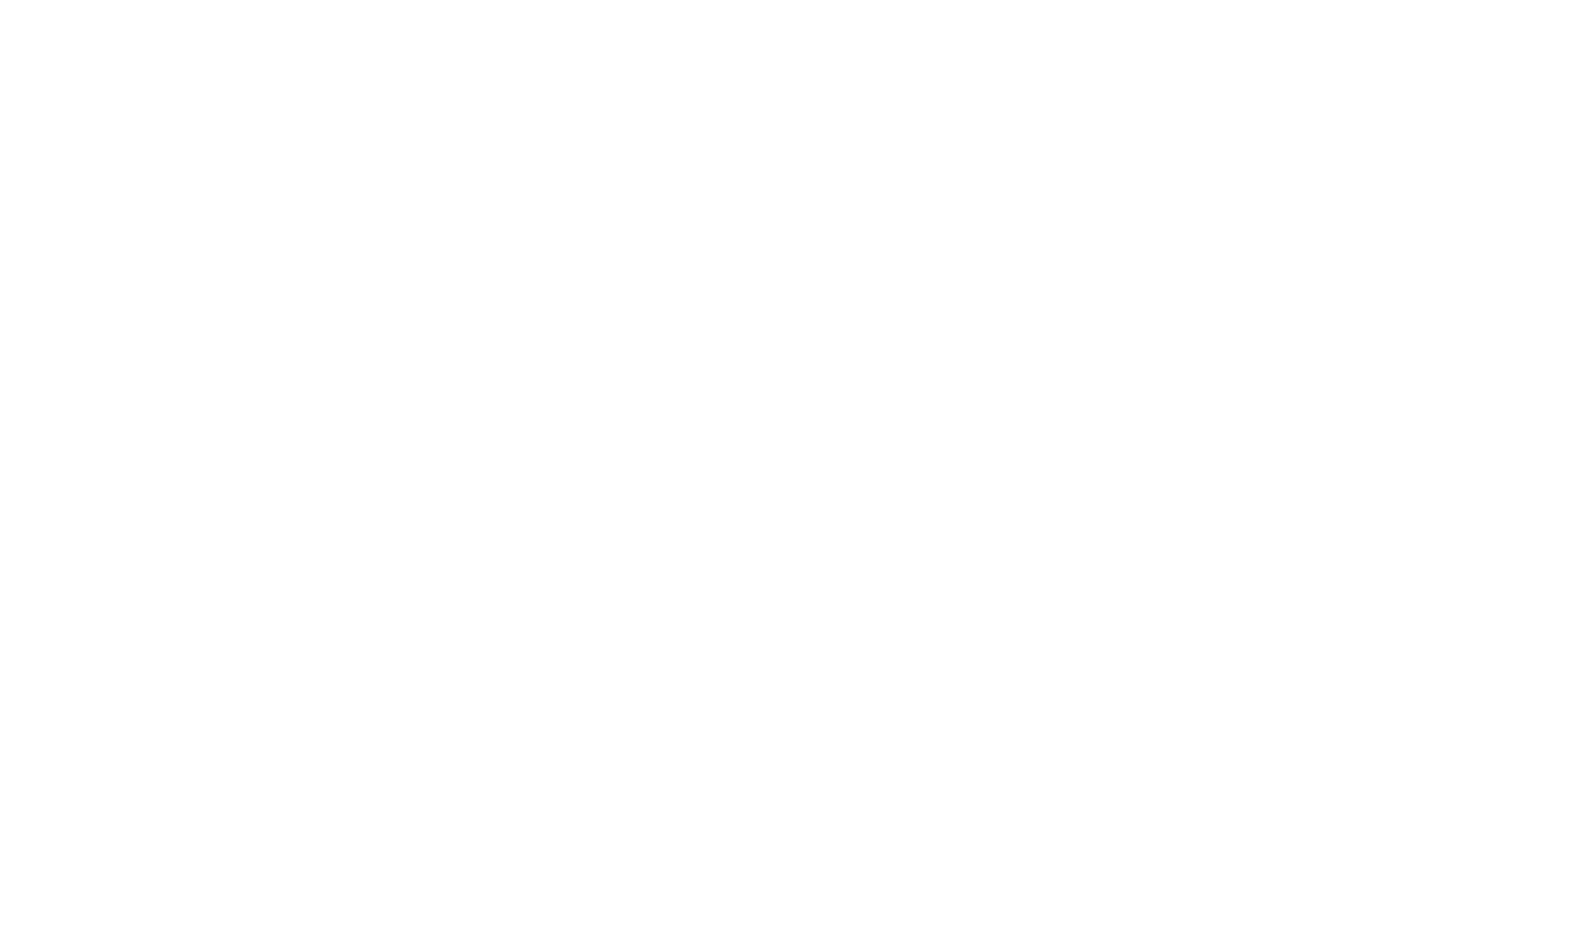

In [15]:
redox_etc = build_pathway('redox_etc', 'Redox Carriers and Electron Transport')
SVG(escher_map.EscherMap(redox_etc.diagram, width='10cm').draw())

## Save the pathways

In [16]:
KB.put(KB.pathways, tca)
KB.put(KB.pathways, oxphos)
KB.put(KB.pathways, redox_etc)